# Eduardo Tirta - Projeto 2 Visão Computacional

## Introdução

Este projeto tem o intuito de compreender qual o background de determinadas imagens e tentar segmentar, assim, podemos obter apenas os objetos em movimentos de certa imagem, além disso, com a imagem segmentada, aplicamos um método de contagem, para saber quantas pessoas existem aproximadamente em um certa foto. Isto é relevante por poder mensurar de forma rápida quantas pessoas passam por certo local

## Técnica

Para chegar no resultado esperado, utilizamos o codebook, que está presente no Artigo 1, esta não é a única forma de obter a segmentação do fundo, possuindo, por exemplo, o método MOG, já presente no openCV, porém, o codebook dá uma melhor performance comparada ao MOG.

## Codebook

O codebook explicado no Artigo 1, cria um codeword para cada pixel da imagem. Em um conjunto de imagens, este codeword vai alterando para descobrir se o pixel faz parte do Background ou do foreground, a partir de cálculos que envolvem o brilho e as cores, e assim, irá formar um codebook, composto por codewords que determinará qual o fundo de uma imagem e qual objetos devem ser segmentados.


Artigo 1: https://insper.blackboard.com/bbcswebdav/pid-519099-dt-content-rid-2893002_2/courses/201862.GRENGELE_201862_0009.VISAOCOMP_ELET_A/1.%20Real-time%20foreground%E2%80%93background%20segmentation%20using%20codebook%20model.pdf

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.image as mpimg
import pickle
import os
import glob
import cv2
%matplotlib inline  
# figure size in inches optional
rcParams['figure.figsize'] = 15 ,12

# Treinamento 

Coloquei o arquivo nesse jupyter pq o codebook resultante era grande demais para ser salvo em um arquivo (resultava em um MemoryError)

In [2]:
def get_dist(pixelRGB,cbRGB):
    x = pixelRGB[0]**2 + pixelRGB[1]**2 + pixelRGB[2]**2
    v = cbRGB[0]**2 + cbRGB[1]**2 + cbRGB[2]**2
    xv = (float(pixelRGB[0])*float(cbRGB[0]) + float(pixelRGB[1])*float(cbRGB[1]) + float(pixelRGB[2])*float(cbRGB[2]))**2
    if(v <=  0):
        v = 1
    p = float(xv)/float(v)
    if(p > x):
        p = x
    colordist = (float(x)-p)**0.5
    return colordist


def get_new_rgb(pixelRGB,codewordRGB, f):
    r = ((f*codewordRGB[0])+ pixelRGB[0])/(f+1)
    g = ((f*codewordRGB[1]) + pixelRGB[1])/(f+1)
    b = ((f*codewordRGB[2]) + pixelRGB[2])/(f+1)
    return [r,g,b]


folder_path = './backgrounds'
 
data_path = os.path.join(folder_path,'*g')
files = glob.glob(data_path)

images = []

for file_in in files:
    img = cv2.imread(file_in)
    images.append(img)

w,h, s = images[0].shape

codebook = [[0 for j in range(h)] for k in range(w)]


epsolon = 14
alfa = 0.4
beta = 1.2
t = 1

##-------------COLINHA ------------------------
#[ (R,G, B), (Imin,Imax, Frequency, lambda, p , q)]
##---------------------------------------------

progress = 0 


for img in images:
    progress += 1
    print('Imagem {0}/{1}'.format(progress,len(images)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(0,len(img)):
        for j in range(0,len(img[i])):
            nowPixel = img[i][j]
            brightness =  (nowPixel[0]**2 + nowPixel[1]**2 + nowPixel[2]**2)**(0.5)
            cb = codebook[i][j]
            codeword = [[nowPixel[0], nowPixel[1], nowPixel[2]], [brightness, brightness,1, t-1, t,t]]
            if(cb != 0):
                append = True
                for cw in cb:
                    #distoraoo RGB
                    colorDist  = get_dist(nowPixel, cw[0])
                    firstBool = colorDist <=  epsolon
                    #brilhos
                    imin = cw[1][1] * alfa
                    imax = min(beta*cw[1][1], cw[1][0]/alfa)
                    secondBool  = (brightness >= imin) and (brightness <= imax)
                    if(firstBool and secondBool):
                        append = False
                        f = cw[1][2]
                        new_rgb = get_new_rgb(nowPixel, cw[0], f)
                        imin = min(brightness,cw[1][0])
                        imax = max(brightness,cw[1][1])
                        f = f + 1
                        lbda = max(cw[1][3],t-cw[1][5])
                        q = t
                        #update existing codeword
                        cw[0] = new_rgb
                        cw[1][0] = imin
                        cw[1][1] = imax
                        cw[1][2] = f
                        cw[1][3] = lbda
                        cw[1][5] = q
                
                if(append):
                    codebook[i][j].append(codeword)
            else:
                codebook[i][j] = [codeword]
    t+=1

size =  len(images)

for i in codebook:
    for j in i:
        filteredCodeword  = [];
        for k in j:
            if(k[1][3] >= size/2 ):
                filteredCodeword.append(k)
        j = filteredCodeword
        
print('Terminou')


Imagem 1/16
Imagem 2/16
Imagem 3/16
Imagem 4/16
Imagem 5/16
Imagem 6/16
Imagem 7/16
Imagem 8/16
Imagem 9/16
Imagem 10/16
Imagem 11/16
Imagem 12/16
Imagem 13/16
Imagem 14/16
Imagem 15/16
Imagem 16/16
Terminou


# Início da Separação / Contagem

In [11]:
folder_path = './pessoascena'
data_path = os.path.join(folder_path,'*g')
files = glob.glob(data_path)
images = []
for file_in in files:
    img = cv2.imread(file_in)
    images.append(img)
    
    
#with open('treinamento.pickle', 'rb') as handle:
 #   codebook = pickle.load(handle)



In [4]:
def get_dist(pixelRGB,cbRGB):
    x = pixelRGB[0]**2 + pixelRGB[1]**2 + pixelRGB[2]**2
    v = cbRGB[0]**2 + cbRGB[1]**2 + cbRGB[2]**2
    xv = (float(pixelRGB[0])*float(cbRGB[0]) + float(pixelRGB[1])*float(cbRGB[1]) + float(pixelRGB[2])*float(cbRGB[2]))**2
    if(v <=  0):
        v = 1
    p = float(xv)/float(v)
    if(p > x):
        p = x
    colordist = (float(x)-p)**0.5
    return colordist


def separate_foreground(inputImage):
    epsolon = 10
    alfa = 0.4
    beta = 1.2
    img = inputImage.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(0,len(img)):
        for j in range(0, len(img[i])):
            inputPixel = img[i][j]
            brightness =  (inputPixel[0]**2 + inputPixel[1]**2 + inputPixel[2]**2)**(0.5)
            cb = codebook[i][j]
            for cw in cb:
                colorDist  = get_dist(inputPixel, cw[0])
                color_condition = float(colorDist) <=  float(epsolon)
                imin = cw[1][1] * alfa
                imax = min(beta*cw[1][1],cw[1][0]/alfa)
                brightness_condition  = (brightness >= imin) and (brightness <= imax)
                if(brightness_condition and color_condition):
                    img[i][j] = [0,0,0]
                else:
                    img[i][j] = [255,255,255]
                    
    imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = np.ones((5,5),np.uint8)
    e = cv2.erode(imgGray,kernel,iterations = 1)
    d = cv2.dilate(e,kernel,iterations = 1)
    return d



In [5]:
from skimage import measure

def count_new_elements(img):
    labels = measure.label(img, neighbors=8, background=0)
    mask = np.zeros(img.shape, dtype="uint8")
    relevant_elements = 0
    
    for label in np.unique(labels):
        if label == 0:
            continue
        labelMask = np.zeros(img.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        if numPixels > 300:
            relevant_elements += 1
            mask = cv2.add(mask, labelMask)
    return mask, relevant_elements
            




In [6]:
def plot_count_elements(imgInput):
    img = imgInput.copy()
    img = separate_foreground(img)   
    mask, number = count_new_elements(img)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(mask)
    ax[1].imshow(imgInput)
    print("Elementos novos na cena: {0}".format(number))

# Testando em diferentes frames

## Teste 1

Elementos novos na cena: 3


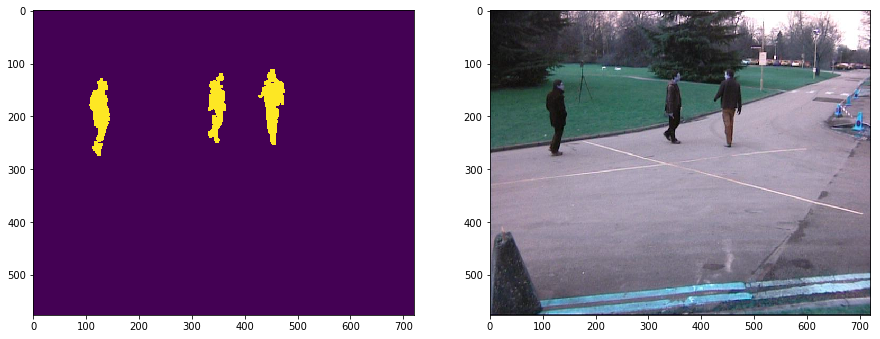

In [15]:
plot_count_elements(images[0])

## Teste 2

Elementos novos na cena: 2


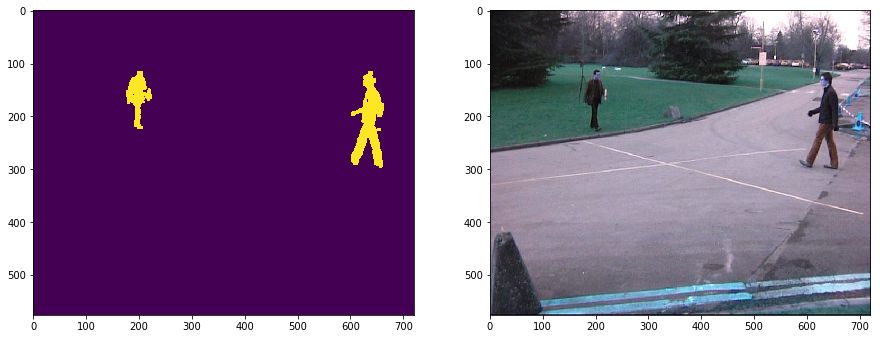

In [16]:
plot_count_elements(images[1])

## Teste 3

Elementos novos na cena: 2


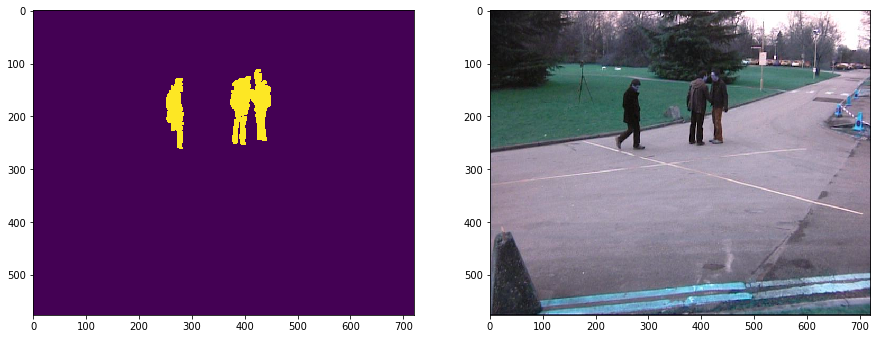

In [17]:
plot_count_elements(images[2])

## Teste 4

Elementos novos na cena: 5


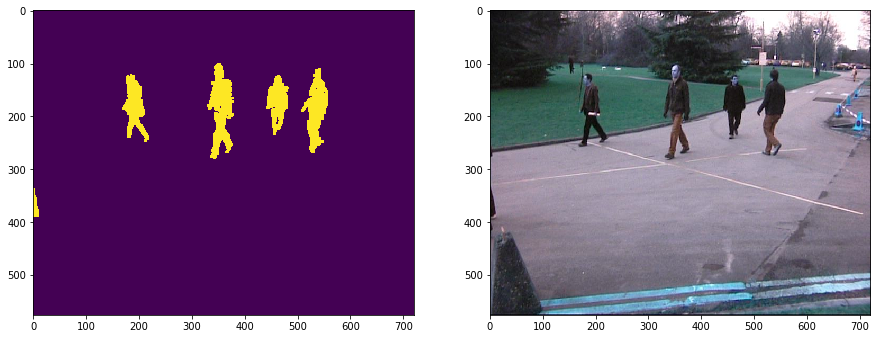

In [18]:
plot_count_elements(images[3])

## Teste 5

Elementos novos na cena: 6


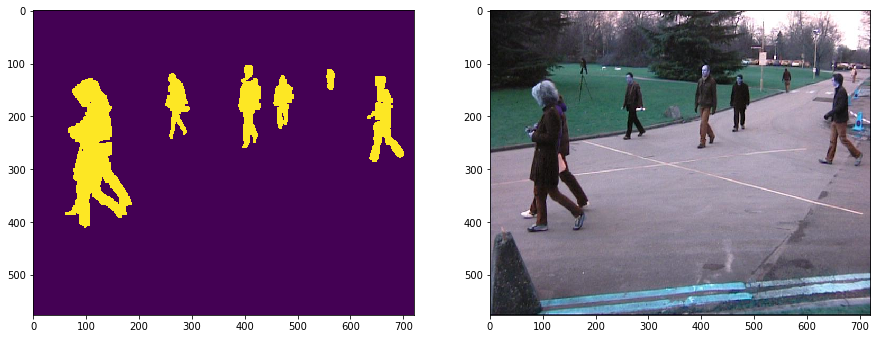

In [19]:
plot_count_elements(images[4])

## Método de Contagem

O método de contagem utilizado se chama detecção de componentes conectados, que em resumo é quantidade de pixels iguais interligados sem interrupção. Ele funciona bem se a sua separação do foreground for muito boa, e ainda assim precisa de um filtro a mais para decidir quão grande deve ser o aglomerado para ser de fato considerado na contagem. A fonte do algortimo utilizado se encontraa seguir:
https://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/

Seu ponto negativo é que pessoas juntas são consideradas somente um elemento pois são um unico aglomerado,para multidões não é um método muito bom.